In [1]:
"""
Quantize the models and evaluate performance post-quantization
Authors: Booy Faassen & Paul Rosero
"""

import tensorflow as tf
import pathlib
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
""" Setup """

test_dir = './data/dataset01/test'
train_dir = './data/dataset01/train'

model_dir = '../../Results/inception/inception/inception_test2_dataset06'

tflite_models_dir = pathlib.Path(model_dir)
tflite_models_dir.mkdir(exist_ok=True, parents=True)

img_height = 224
img_width = 224
class_names = ['0.0', '1.0']

batch_size_train = 32 # set to size of total test set
batch_size_test = len(os.listdir(test_dir+'/1.0/')) + len(os.listdir(test_dir+'/0.0/')) # total test set

In [3]:
""" Load train data & initialize representative_data_gen() function"""

def load_train_data():
    train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     labels='inferred',
                                                                     seed=123,
                                                                     label_mode="categorical",
                                                                     color_mode='rgb',
                                                                     batch_size=batch_size_train, # number of images to process at a time 
                                                                     image_size=(img_height, img_width) # convert all images to be 224 x 224
                                                                    )
    return train_data


def representative_data_gen():
    train_data = load_train_data()
    for input_value,_ in train_data.take(100):
        input_value=np.expand_dims(input_value[0], axis=0).astype(np.float32)
        yield [input_value]

In [3]:
########################### IMPORT THE MODEL ###################################################
model=tf.keras.models.load_model(model_dir)
################################################################################################

In [4]:
############################# CONVERT MODEL TO TENSORFLOW LITE ###################################################
# Source: https://www.tensorflow.org/lite/performance/post_training_float16_quant
converter = tf.lite.TFLiteConverter.from_keras_model(model) # instantiate a converter for Keras model
#converter_2 = tf.lite.TFLiteCOnverter.from_saved_model(model) # for SavedModel objects instead of Keras. Added by Booy
tflite_model = converter.convert()
tflite_model_file = tflite_models_dir/("effi_model.tflite")
tflite_model_file.write_bytes(tflite_model)
##############################################################################################

INFO:tensorflow:Assets written to: C:\Users\booyf\AppData\Local\Temp\tmpb06pm9qi\assets


INFO:tensorflow:Assets written to: C:\Users\booyf\AppData\Local\Temp\tmpb06pm9qi\assets


87537056

In [6]:
 ################## Post-training float16 quantization ##########################################
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/("effi_model_quant_f16.tflite")
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

INFO:tensorflow:Assets written to: C:\Users\booyf\AppData\Local\Temp\tmpqyrwom8f\assets


INFO:tensorflow:Assets written to: C:\Users\booyf\AppData\Local\Temp\tmpqyrwom8f\assets


8088612

In [7]:
############### Post-training dynamic range quantization #######################################
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/("effi_model_quant.tflite")
tflite_model_quant_file.write_bytes(tflite_quant_model)
##############################################################################################

INFO:tensorflow:Assets written to: C:\Users\booyf\AppData\Local\Temp\tmppfdz_6is\assets


INFO:tensorflow:Assets written to: C:\Users\booyf\AppData\Local\Temp\tmppfdz_6is\assets


4545424

In [8]:
################## Post-training integer quantization ##########################################

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen # this step is to also quantize variable data (input/output/ intermediaries between layers)
tflite_model_quant_float = converter.convert()
tflite_model_quant_float_file = tflite_models_dir/("effi_model_quant_float.tflite")
tflite_model_quant_float_file.write_bytes(tflite_model_quant_float) # returned 56572440 bytes
#############################################################################################

INFO:tensorflow:Assets written to: C:\Users\booyf\AppData\Local\Temp\tmp6f4gixgt\assets


INFO:tensorflow:Assets written to: C:\Users\booyf\AppData\Local\Temp\tmp6f4gixgt\assets
C:\Users\booyf\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Found 1969 files belonging to 2 classes.


4907128

In [9]:
######################## Integer-only quantization ##########################################
# Source: https://www.tensorflow.org/lite/performance/post_training_integer_quant

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int = converter.convert()
tflite_model_quant_int_file = tflite_models_dir/("effi_model_quant_int.tflite")
tflite_model_quant_int_file.write_bytes(tflite_model_quant_int)
#############################################################################################

INFO:tensorflow:Assets written to: C:\Users\booyf\AppData\Local\Temp\tmp46axo_mw\assets


INFO:tensorflow:Assets written to: C:\Users\booyf\AppData\Local\Temp\tmp46axo_mw\assets
C:\Users\booyf\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Found 1969 files belonging to 2 classes.


4907152

In [10]:
""" Load all quantized models into the interpreters """

# Re-initialise variables containing model files if above quantization methods have not been called
tflite_model_file = tflite_models_dir/("effi_model.tflite")
tflite_model_fp16_file = tflite_models_dir/("effi_model_quant_f16.tflite")
tflite_model_quant_file = tflite_models_dir/("effi_model_quant.tflite")
tflite_model_quant_float_file = tflite_models_dir/("effi_model_quant_float.tflite")
tflite_model_quant_int_file = tflite_models_dir/("effi_model_quant_int.tflite")


# The interpreter is to run inference on embedded device
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

interpreter_quant_float = tf.lite.Interpreter(model_path=str(tflite_model_quant_float_file))
interpreter_quant_float.allocate_tensors()

interpreter_quant_int = tf.lite.Interpreter(model_path=str(tflite_model_quant_int_file))
interpreter_quant_int.allocate_tensors()

In [11]:
""" Load test data """

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                labels='inferred',
                                                                seed=123,
                                                                label_mode="categorical",
                                                                color_mode='rgb',
                                                                batch_size=32*3, #batch_size_test, 
                                                                image_size=(img_height, img_width)
                                                                )

Found 655 files belonging to 2 classes.


In [12]:
"""
Show 3 images with their predictions and actual labels, respectively.
"""

def show_predictions(interpreter, test_data):
    # Get input and output tensors.
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    img_batch, label_batch = next(iter(test_data)) # fetch a batch from the test data.
    
    plt.figure(figsize=(10, 10)) # initialize plots
    
    for i in range(3):
        input_data = tf.expand_dims(img_batch[i], axis=0) # convert from (224, 224, 3) to (1, 224, 224, 3).
        interpreter.set_tensor(input_index, input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_index) # `get_tensor()` returns a copy of the tensor data.
        
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        label = int(label_batch[i][1].numpy())
        title = "Actual: "  + class_names[label] + ". Predicted: " + class_names[round(output_data[0][1])]
        plt.title(title)
        plt.axis("off")

In [22]:
"""
Evaluate the quantized model with the test set.
Returns a list of all actual labels and predicted labels, respectively.
Partially copied from: https://www.tensorflow.org/lite/performance/post_training_float16_quant
"""

def evaluate_model(interpreter, test_data):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    img_batch, label_batch = iter(test_data).get_next()
    label_list = []
    for i in range(len(label_batch)):
        label_list.append(int(label_batch.numpy()[i][1]))

  # Run predictions on every image in test_data.
    prediction_digits = []
    for test_image in img_batch:
        # Pre-processing: add batch dimension and convert to float32 to match with the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32) # either np.uint8 or np.float32.
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
    return label_list, prediction_digits

In [ ]:
print(evaluate_model(interpreter_quant_int))

0.6551724137931034


In [14]:
"""
Plots the confusion matrixs for a given list of actual labels and corresponding predictions.
Partially copied from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics
"""

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions) # predictions > p) # I took this out
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p)) # I am not sure if it actually evaluates at 0.5...?
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives:', cm[0][0])
    print('False Positives:', cm[0][1])
    print('False Negatives:', cm[1][0])
    print('True Positives:', cm[1][1])
    print('Accuracy:', ((cm[0][0]+cm[1][1]) / (cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])))
    print('Recall:', (cm[1][1]/(cm[1][1]+cm[1][0])))
    print('Precision:', (cm[1][1]/(cm[1][1]+cm[0][1]))) 

True Negatives: 63
False Positives: 0
False Negatives: 24
True Positives: 9
Accuracy: 0.75
Recall: 0.2727272727272727
Precision: 1.0


'\ninterpreter\ninterpreter_fp16\ninterpreter_quant # TAKES VERY LONG\ninterpreter_quant_float # TAKES VERY LONG\ninterpreter_quant_int # TAKES VERY LONG\n'

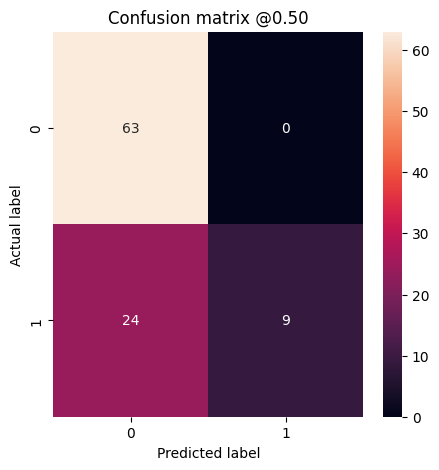

In [21]:
label_list, prediction_digits = evaluate_model(interpreter, test_data)
plot_cm(label_list, prediction_digits)

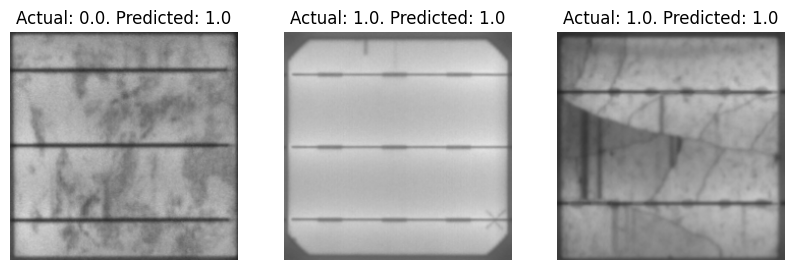

In [57]:
show_predictions(interpreter, test_data)

In [87]:
""" print sizes of all quantized models """

size_tf = os.path.getsize(tflite_model_file)
size_fp16_tflite = os.path.getsize(tflite_model_fp16_file)
size_quant_tflite = os.path.getsize(tflite_model_quant_file)
size_quant_float_tflite = os.path.getsize(tflite_model_quant_float_file)
#size_quant_int_tflite = os.path.getsize(tflite_model_quant_int_file)

print("######################################")
print( f"TensorFlow Lite model: \t \t \t \t {size_tf} bytes")
print( f"Post-training float16 quantization: \t \t {size_fp16_tflite} bytes")
print( f"Post-training dynamic range quantization: \t {size_quant_tflite} bytes")
print( f"Post-training integer quantization: \t \t {size_quant_float_tflite} bytes")
#print( f"Integer-only quantization: \t \t {size_quant_int_tflite} bytes")
print("######################################")

######################################
TensorFlow Lite model: 	 	 	 	 217555324 bytes
Post-training float16 quantization: 	 	 108919004 bytes
Post-training dynamic range quantization: 	 55644792 bytes
Post-training integer quantization: 	 	 56572440 bytes
######################################
